In [1]:
# @title Plots for Decoherence of Chiral Magnon Edge Modes in a Topological Bosonic Chern Insulator


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

plt.rcParams.update({
    "figure.figsize": (6.4, 4.0),
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "lines.linewidth": 1.2,
    "axes.grid": True,
    "grid.alpha": 0.2,
})

linestyles = ['-', '--', '-.', ':']


hbar    = 1.054571817e-34
k_B     = 1.380649e-23
eV_to_J = 1.602176634e-19
meV_to_J = 1e-3 * eV_to_J


tJ_meV     = 5.0
tD_meV     = 1.0
onsite_meV = 10.0

tJ     = tJ_meV
tD     = tD_meV
onsite = onsite_meV

W   = 40
Nk  = 301

EDGE_THRESHOLD = 0.10

gamma0_relax = 1.0e8
gamma0_phi   = 5.0e7

T_list = [2.0, 10.0, 50.0]


nn_vecs = [
    np.array([0.0,  1.0/np.sqrt(3.0)]),
    np.array([0.5, -0.5/np.sqrt(3.0)]),
    np.array([-0.5,-0.5/np.sqrt(3.0)]),
]

a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3.0)/2.0])

b_A = np.array([0.0, 0.0])
b_B = np.array([0.0, 1.0/np.sqrt(3.0)])

def index_A(n): return 2*n
def index_B(n): return 2*n + 1

def build_zigzag_coords(W):
    coords = []
    sublat = []
    for n in range(W):
        Rn = n * a2
        coords.append(Rn + b_A); sublat.append(0)
        coords.append(Rn + b_B); sublat.append(1)
    return np.array(coords), np.array(sublat)

coords, sublat = build_zigzag_coords(W)
N_sites = coords.shape[0]


pos_dict = {}
for idx in range(N_sites):
    key = (round(float(coords[idx, 0]), 6), round(float(coords[idx, 1]), 6))
    pos_dict[key] = idx

def build_ribbon_H(kx, tJ=tJ, tD=tD, onsite=onsite):
    """
    Construct N_sites x N_sites Hamiltonian for zigzag ribbon.
    All energies in meV.
    """
    N = N_sites
    H = np.zeros((N, N), dtype=complex)


    for i in range(N):
        H[i, i] = onsite


    for n in range(W):
        ia = index_A(n)
        posA = coords[ia]
        for v in nn_vecs:
            target = posA + v
            for m in (-1, 0, 1):
                shifted = target - m * a1
                key = (round(float(shifted[0]), 6), round(float(shifted[1]), 6))
                if key in pos_dict:
                    j = pos_dict[key]
                    if sublat[j] != 1:
                        continue
                    phase = np.exp(1j * m * kx)
                    H[ia, j] += -tJ * phase
                    H[j, ia] += -tJ * np.conj(phase)
                    break


    for i in range(N):
        pos_i = coords[i]
        for p in range(3):
            for q in range(3):
                if p == q:
                    continue
                v2 = nn_vecs[p] - nn_vecs[q]
                target = pos_i + v2
                for m in (-1, 0, 1):
                    shifted = target - m * a1
                    key = (round(float(shifted[0]), 6), round(float(shifted[1]), 6))
                    if key in pos_dict:
                        j = pos_dict[key]
                        if sublat[j] != sublat[i]:
                            continue
                        crossz = nn_vecs[p][0]*nn_vecs[q][1] - nn_vecs[p][1]*nn_vecs[q][0]
                        nu = 1.0 if crossz > 0 else -1.0
                        amp = 1j * tD * nu
                        phase = np.exp(1j * m * kx)
                        H[i, j] += amp * phase
                        H[j, i] += np.conj(amp * phase)
                        break

    H = 0.5 * (H + H.conj().T)
    return H

def ribbon_spectrum_and_edge_branch_continuous(edge_threshold=EDGE_THRESHOLD):

    kx_vals = np.linspace(-np.pi, np.pi, Nk)
    eigs_meV = np.zeros((Nk, N_sites))
    vecs = np.zeros((Nk, N_sites, N_sites), dtype=complex)

    top_indices = [index_A(0), index_B(0), index_A(1), index_B(1)]

    for i, kx in enumerate(kx_vals):
        H = build_ribbon_H(kx)
        w, v = eigh(H)
        idx = np.argsort(w)
        w = w[idx]
        v = v[:, idx]
        eigs_meV[i, :] = np.real(w)
        vecs[i, :, :] = v

    k0 = Nk // 2
    v_mid = vecs[k0]
    w_mid = eigs_meV[k0]
    edge_weight_mid = np.sum(np.abs(v_mid[top_indices, :])**2, axis=0)
    seed_idx = np.argmax(edge_weight_mid)

    edge_branch = np.zeros(Nk)
    edge_weight = np.zeros(Nk)

    edge_branch[k0] = w_mid[seed_idx]
    edge_weight[k0] = edge_weight_mid[seed_idx]
    prev_vec = v_mid[:, seed_idx]

    for i in range(k0+1, Nk):
        v_here = vecs[i]
        overlaps = np.abs(v_here.conj().T @ prev_vec)**2
        new_idx = np.argmax(overlaps)
        edge_branch[i] = eigs_meV[i, new_idx]
        edge_weight[i] = np.sum(np.abs(v_here[top_indices, new_idx])**2)
        prev_vec = v_here[:, new_idx]

    prev_vec = vecs[k0][:, seed_idx]
    for i in range(k0-1, -1, -1):
        v_here = vecs[i]
        overlaps = np.abs(v_here.conj().T @ prev_vec)**2
        new_idx = np.argmax(overlaps)
        edge_branch[i] = eigs_meV[i, new_idx]
        edge_weight[i] = np.sum(np.abs(v_here[top_indices, new_idx])**2)
        prev_vec = v_here[:, new_idx]

    mask = edge_weight >= edge_threshold
    edge_branch_masked = np.where(mask, edge_branch, np.nan)

    return kx_vals, eigs_meV, edge_branch_masked

def bose_occupation_meV(E_meV, T_K):
    """Bose factor n_B for energy in meV, T in K."""
    if T_K <= 0.0 or E_meV <= 0.0:
        return 0.0
    E_J = E_meV * meV_to_J
    x = E_J / (k_B * T_K)
    if x > 100.0:
        return 0.0
    return 1.0 / (np.exp(x) - 1.0)

def gamma_relax_meV(E_meV, T_K):
    """
    Phenomenological relaxation:
        gamma_relax(E,T) = gamma0_relax * (E/onsite) * [1 + n_B(E)].
    Returns s^{-1}.
    """
    if E_meV <= 0.0:
        return 0.0
    nB = bose_occupation_meV(E_meV, T_K)
    return gamma0_relax * (E_meV / onsite_meV) * (1.0 + nB)

def gamma_phi(T_K):
    """
    Phenomenological pure dephasing:
        gamma_phi(T) = gamma0_phi * (T / 10 K).
    Returns s^{-1}.
    """
    return gamma0_phi * (T_K / 10.0)

def make_figure_bands(kx_vals, eigs_meV, edge_branch_meV):
    fig, ax = plt.subplots()
    for j in range(eigs_meV.shape[1]):
        ax.plot(kx_vals, eigs_meV[:, j], color='0.7', alpha=0.2, linewidth=0.8)
    ax.plot(kx_vals, edge_branch_meV, linestyle='-', linewidth=1.6, label='edge mode')
    ax.set_xlabel(r'$k_x$')
    ax.set_ylabel(r'$E(k)$ (meV)')
    ax.set_title('Ribbon spectrum with chiral magnon edge mode')
    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig("placeholder_bands.png", dpi=300)
    plt.close(fig)

def make_figure_gamma_vs_k(kx_vals, edge_branch_meV):
    fig, ax = plt.subplots()
    for i, T in enumerate(T_list):
        gamma_phi_val = gamma_phi(T)
        Gamma_k = []
        for E_meV in edge_branch_meV:
            if np.isnan(E_meV):
                Gamma_k.append(np.nan)
            else:
                g_rel = gamma_relax_meV(E_meV, T)
                Gamma_k.append(g_rel + 2.0 * gamma_phi_val)
        Gamma_k = np.array(Gamma_k)
        ax.plot(kx_vals, Gamma_k,
                linestyle=linestyles[i % len(linestyles)],
                label=rf'$T={T:.0f}\,\mathrm{{K}}$')
    ax.set_xlabel(r'$k_x$')
    ax.set_ylabel(r'$\Gamma_k$ (s$^{-1}$)')
    ax.set_title(r'Decoherence rate $\Gamma_k$ vs $k_x$ for different $T$')
    ax.set_yscale('log')
    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig("placeholder_gamma_k.png", dpi=300)
    plt.close(fig)

def make_figure_Ckt(kx_vals, edge_branch_meV):
    Tmid = T_list[1]
    gamma_phi_val = gamma_phi(Tmid)

    t_max = 20e-9
    t = np.linspace(0.0, t_max, 800)

    valid = np.where(~np.isnan(edge_branch_meV))[0]
    if len(valid) < 3:
        idxs = valid
    else:
        idxs = [valid[len(valid)//6], valid[len(valid)//2], valid[5*len(valid)//6]]

    fig, ax = plt.subplots()
    for idx in idxs:
        E_meV = edge_branch_meV[idx]
        E_J   = E_meV * meV_to_J
        omega_k = E_J / hbar
        g_rel = gamma_relax_meV(E_meV, Tmid)
        Gamma = g_rel + 2.0 * gamma_phi_val
        C_t = np.exp(-0.5 * Gamma * t) * np.cos(omega_k * t)
        ax.plot(t*1e9, C_t, label=rf'$k_x \approx {kx_vals[idx]:.2f}$')

    ax.set_xlabel(r'$t$ (ns)')
    ax.set_ylabel(r'$\mathrm{Re}\,C_k(t)$')
    ax.set_title(r'Coherence decay $C_k(t)$ at $T = %.0f\,\mathrm{K}$' % Tmid)
    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig("placeholder_Ckt.png", dpi=300)
    plt.close(fig)

def entanglement_entropy_from_r(r):
    nu = 0.5 * np.cosh(2.0 * r)
    x1 = nu + 0.5
    x2 = nu - 0.5
    return x1 * np.log(x1) - x2 * np.log(x2)

def make_figure_entanglement(edge_branch_meV):
    r0 = 1.0
    valid = np.where(~np.isnan(edge_branch_meV))[0]
    if len(valid) == 0:
        E_typ_meV = np.nanmax(edge_branch_meV)
    else:
        E_typ_meV = np.max(edge_branch_meV[valid])

    Tmid = T_list[1]
    gamma_eff = gamma_relax_meV(E_typ_meV, Tmid) + 2.0 * gamma_phi(Tmid)

    t_max = 20e-9      # 20 ns
    t = np.linspace(0.0, t_max, 800)
    r_t = r0 * np.exp(-0.5 * gamma_eff * t)
    S_t = entanglement_entropy_from_r(r_t)

    fig, ax = plt.subplots()
    ax.plot(t*1e9, S_t, linestyle='-')
    ax.set_xlabel(r'$t$ (ns)')
    ax.set_ylabel(r'$S_{\mathrm{ent}}(t)$')
    ax.set_title('Entanglement entropy decay (toy two-mode edge magnons)')
    fig.tight_layout()
    fig.savefig("placeholder_entanglement.png", dpi=300)
    plt.close(fig)

def main():
    print("Computing zigzag FM Haldane ribbon spectrum and edge branch (meV)...")
    kx_vals, eigs_meV, edge_branch_meV = ribbon_spectrum_and_edge_branch_continuous()

    print("Making Figure 1 (bands + edge mode)...")
    make_figure_bands(kx_vals, eigs_meV, edge_branch_meV)

    print("Making Figure 2 (Gamma_k vs k)...")
    make_figure_gamma_vs_k(kx_vals, edge_branch_meV)

    print("Making Figure 3 (C_k(t) decay)...")
    make_figure_Ckt(kx_vals, edge_branch_meV)

    print("Making Figure 4 (entanglement entropy vs t)...")
    make_figure_entanglement(edge_branch_meV)

    print("Done. Files saved as:")
    print("  placeholder_bands.png")
    print("  placeholder_gamma_k.png")
    print("  placeholder_Ckt.png")
    print("  placeholder_entanglement.png")

if __name__ == "__main__":
    main()


Computing zigzag FM Haldane ribbon spectrum and edge branch (meV)...
Making Figure 1 (bands + edge mode)...
Making Figure 2 (Gamma_k vs k)...
Making Figure 3 (C_k(t) decay)...
Making Figure 4 (entanglement entropy vs t)...
Done. Files saved as:
  placeholder_bands.png
  placeholder_gamma_k.png
  placeholder_Ckt.png
  placeholder_entanglement.png


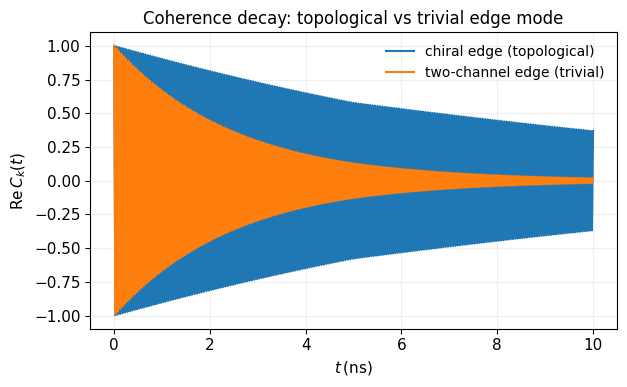

In [3]:
# @title Comparison of Topological vs Trivial edges


import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (6.4, 4.0),
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.2,
})

hbar = 1.054571817e-34
k_B  = 1.380649e-23

f_edge = 20e9
omega_edge = 2.0 * np.pi * f_edge

Gamma_top  = 2.0e8
Gamma_triv = 8.0e8

t_max_ns = 10.0
N_t = 2000
t_ns = np.linspace(0.0, t_max_ns, N_t)
t = t_ns * 1e-9

C_top  = np.exp(-0.5 * Gamma_top  * t) * np.cos(omega_edge * t)
C_triv = np.exp(-0.5 * Gamma_triv * t) * np.cos(omega_edge * t)

fig, ax = plt.subplots()

ax.plot(t_ns, C_top,  label=r'chiral edge (topological)',  color='C0')
ax.plot(t_ns, C_triv, label=r'two-channel edge (trivial)', color='C1')

ax.set_xlabel(r'$t \, (\mathrm{ns})$')
ax.set_ylabel(r'$\mathrm{Re}\,C_k(t)$')
ax.set_title(r'Coherence decay: topological vs trivial edge mode')

ax.legend(frameon=False)
fig.tight_layout()
fig.savefig("placeholder_Ckt_top_vs_trivial.png", dpi=300)
plt.show()
